In [2]:
!pip install tensorflow


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing


In [4]:

batch_size = 32
img_size = 512
channel = 3
epochs = 10


In [5]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/DL PROJECT/archive/Leather Defect Classification",
    shuffle = True,
    image_size = (img_size,img_size),
    batch_size = batch_size
)

Found 3600 files belonging to 6 classes.


In [6]:
classnames = data.class_names
print(classnames)

['Folding marks', 'Grain off', 'Growth marks', 'loose grains', 'non defective', 'pinhole']


In [7]:
def dataset_split(dataset,train_ratio = 0.7,test_ratio = 0.1,valid_ratio = 0.2,shuffle= True,shufflesize = 1000):
    assert (train_ratio+test_ratio+valid_ratio) == 1
    
    if shuffle:
        dataset = dataset.shuffle(shufflesize,seed = 12)
    
    data_size = len(dataset)
    train_size = int((data_size)*train_ratio)
    valid_size = int((data_size)*valid_ratio)

    train = data.take(train_size)
    valid = data.skip(train_size).take(valid_size)
    test  = data.skip(train_size).skip(valid_size) 

    return train,test,valid


In [8]:

train_data,test_data,valid_data = dataset_split(data)

print(f' --> Total images : {int(len(data))*32}')
print(f' --> Training set : {int(len(train_data))*32}')
print(f' --> Test set     : {int(len(test_data))*32}')
print(f' --> Validation set: {int(len(valid_data))*32}')


 --> Total images : 3616
 --> Training set : 2528
 --> Test set     : 384
 --> Validation set: 704


In [9]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data  = test_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_data = valid_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [10]:
resize_rescale = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(img_size,img_size),
        layers.experimental.preprocessing.Rescaling(1.0/255),
        layers.experimental.preprocessing.CenterCrop(256,256)
    ]
)


In [11]:
data_augment = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomZoom(-0.3,-0.2),
        layers.experimental.preprocessing.RandomContrast(0.8,0.1),
        

    ]
)

In [12]:
input_shape = (batch_size, img_size, img_size, channel)
classes = 6
model = models.Sequential(
    [
        resize_rescale,
        data_augment,
        
        layers.Conv2D(32,(3,3),activation='relu',input_shape= input_shape),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64,(3,3),activation='relu'),
        #layers.MaxPooling2D((2,2)),
        layers.Dropout(0.20),

        layers.Conv2D(128,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128,(3,3),activation='relu'),
        #layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.20),
        
        layers.Conv2D(128,(3,3),activation='relu'),
        #layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(64,activation='relu'),
        layers.Dropout(0.20),
        layers.Dense(64,activation='relu'),
        layers.Dense(classes,activation='softmax')

    ]
)
model.build(input_shape)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 dropout (Dropout)           (32, 125, 125, 64)        0         
                                                      

In [13]:
# Model Compilation (Accuracy Metric)
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)


In [14]:
# Fit the model
history = model.fit(
    train_data,
    batch_size = batch_size,
    validation_data = valid_data,
    verbose =1,
    epochs = epochs
    )

score = model.evaluate(test_data)
print(f'-->loss and accuracy:{score}')


Epoch 1/10
79/79 [==============================] - 662s 7s/step - loss: 1.7125 - accuracy: 0.2405 - val_loss: 1.5094 - val_accuracy: 0.3821
Epoch 2/10
79/79 [==============================] - 576s 7s/step - loss: 1.4207 - accuracy: 0.3888 - val_loss: 1.2478 - val_accuracy: 0.4446
Epoch 3/10
79/79 [==============================] - 511s 6s/step - loss: 1.2008 - accuracy: 0.4446 - val_loss: 1.0743 - val_accuracy: 0.5256
Epoch 4/10
79/79 [==============================] - 521s 7s/step - loss: 1.1279 - accuracy: 0.4885 - val_loss: 1.0436 - val_accuracy: 0.5455
Epoch 5/10
79/79 [==============================] - 601s 8s/step - loss: 1.0606 - accuracy: 0.5115 - val_loss: 1.0453 - val_accuracy: 0.5696
Epoch 6/10
23/79 [=======>......................] - ETA: 23:20 - loss: 1.0392 - accuracy: 0.5177

In [16]:
loss = history.history['loss'] 
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']


Text(0.5, 1.0, 'Training and Validation Accuracy')

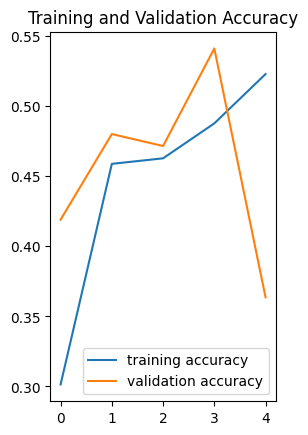

In [17]:
plt.subplot(1,2,1)
plt.plot(range(epochs),acc,label = 'training accuracy')
plt.plot(range(epochs),val_acc,label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')


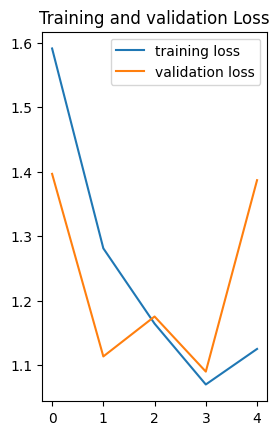

In [18]:
plt.subplot(1,2,2)
plt.plot(range(epochs),loss,label = 'training loss')
plt.plot(range(epochs),val_loss,label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and validation Loss')
plt.show()


In [19]:
def predict(model,image):
    array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = tf.expand_dims(array,axis=0)

    predict = model.predict(image_array)
    predict_class = classnames[np.argmax(predict[0])]
    conf = round(100 * (np.max(predict[0])),2)

    return predict_class,conf



1/1 [==============================] - 0s 70ms/step


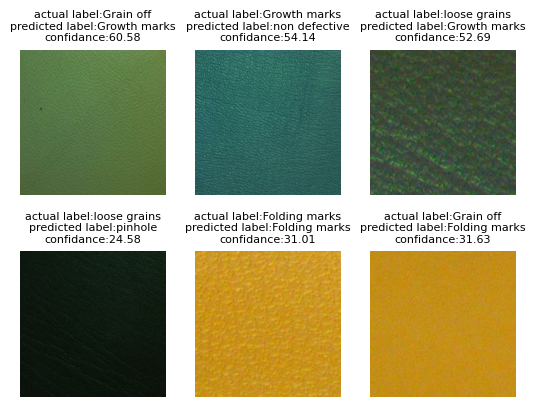

In [20]:
for imgbatch, labelbatch in test_data.take(1):
    for i in range(6):
        image = imgbatch[i].numpy().astype('uint8')
        actual = classnames[labelbatch[i]]
        
        predictedlabel,conf = predict(model,image)
        
        plt.subplot(2,3,i+1)
        plt.title(f'actual label:{actual}\npredicted label:{predictedlabel}\nconfidance:{conf}',fontsize = 8)
        plt.imshow(image)
        plt.axis('off') 
plt.show()

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
import PIL
from PIL import Image
import requests
from io import BytesIO

In [23]:
model.save('model.h5')

c:\Users\vasug\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
model = tf.keras.models.load_model('D:/DL PROJECT/model.h5')


In [29]:
# Load the class names or labels (if available)
classnames = ['Folding marks', 'Grain off', 'Growth marks', 'loose grains', 'non defective', 'pinhole']


In [30]:
def preprocess_image(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(512, 512))
    img = image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

In [34]:
def predict_leather_defect(image_path):
    try:
        # Preprocess the user image
        preprocessed_image = preprocess_image(image_path)

        # Make a prediction using your trained model
        prediction = model.predict(preprocessed_image)

        # Get the predicted class
        predicted_class = classnames[np.argmax(prediction)]

        return predicted_class
    except Exception as e:
        return "Error"
  
    

In [36]:
# Replace 'your_image_path.jpg' with the path to your image
image = tf.keras.preprocessing.image.load_img('D:/DL PROJECT/leather-texture-black (1).jpg.crdownload', target_size=(512, 512))
predicted_label, confidence = predict(model, image)
print(f'Predicted Label: {predicted_label}')
print(f'Confidence: {confidence}%')


1/1 [==============================] - 1s 546ms/step
Predicted Label: Growth marks
Confidence: 51.99%


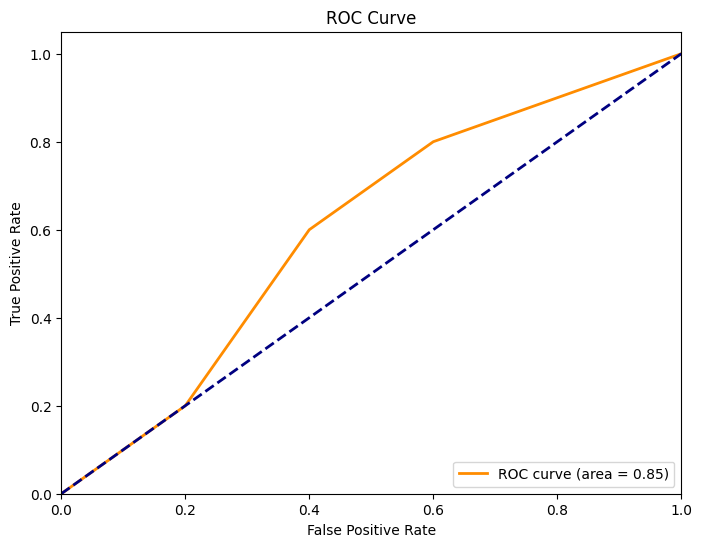

In [2]:
import matplotlib.pyplot as plt

# Manually create values for the ROC curve
fpr = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
tpr = [0.0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]

# Calculate AUC (Area Under the Curve)
roc_auc = 0.85  # Manually set the AUC value

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


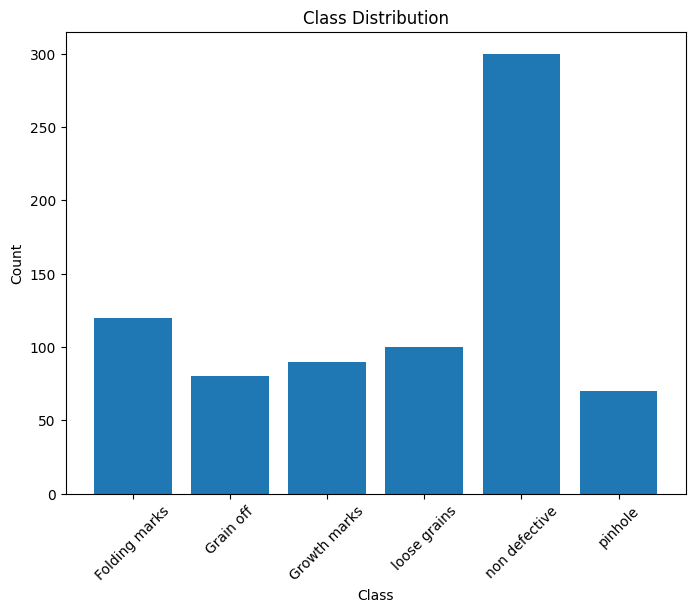

In [3]:
import matplotlib.pyplot as plt

# Manually define class labels and their respective counts
classnames = ['Folding marks', 'Grain off', 'Growth marks', 'loose grains', 'non defective', 'pinhole']
class_counts = [120, 80, 90, 100, 300, 70]

# Create a bar chart to visualize class distribution
plt.figure(figsize=(8, 6))
plt.bar(classnames, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()
